In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sun_and_cloud.csv to sun_and_cloud.csv


In [ ]:
import pandas as pd
import numpy as np

# data = pd.read_csv('Nonscaled_Learn_Ready_NEW.csv',encoding = 'cp949')
data = pd.read_csv('sun_and_cloud.csv',encoding='cp949')
data.drop(columns=['전운량(10분위)','시정(10m)','중하층운량(10분위)','지면온도(°C)'],inplace=True)

print(data.info())
print('----------------------')
print(data.max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시간         26304 non-null  int64  
 1   일조(hr)     26304 non-null  float64
 2   일사(MJ/m2)  26304 non-null  float64
 3   전력거래량      26304 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 822.1 KB
None
----------------------
시간           23.000000
일조(hr)        1.000000
일사(MJ/m2)     3.780000
전력거래량        10.807822
dtype: float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
result = scaler.fit_transform(data)
df_scld= pd.DataFrame(data=result,columns=data.columns)

In [ ]:
x_train = df_scld.iloc[:25560,:-1] # 18년 ~ 20년 11월 --> Train & Validation
y_train = df_scld.iloc[:25560,-1] # 18년 ~ 20년 11월 --> Train & Validation

x_pred = df_scld.iloc[25560:,:-1] # 20년 12월- 예측용 변수 --> Preidction
y_pred = df_scld.iloc[25560:,-1] # 20년 12월 - 예측용 정답 --> Preidction


# --- Ensemble 을 위해서 np.array 형태로 data type 전환해보기
x_train = np.array(x_train)
y_train = np.array(y_train)

x_pred = np.array(x_pred)
y_pred = np.array(y_pred)

print(x_train,'\n',x_pred,'\n',y_train,'\n',y_pred)
print('------------------------------------------------------------------------------------------------------------------------')
print(x_train.shape,'\n',x_pred.shape,'\n',y_train.shape,'\n',y_pred.shape)

[[0.         0.         0.        ]
 [0.04347826 0.         0.        ]
 [0.08695652 0.         0.        ]
 ...
 [0.91304348 0.         0.        ]
 [0.95652174 0.         0.        ]
 [1.         0.         0.        ]] 
 [[0.         0.         0.        ]
 [0.04347826 0.         0.        ]
 [0.08695652 0.         0.        ]
 ...
 [0.91304348 0.         0.        ]
 [0.95652174 0.         0.        ]
 [1.         0.         0.        ]] 
 [0.         0.         0.         ... 0.00438201 0.         0.        ] 
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.27051815e-03
 1.28405242e-01 3.96698706e-01 6.28714648e-01 7.51850928e-01
 7.73565386e-01 7.27539462e-01 5.12777413e-01 1.64768628e-01
 4.04024974e-02 2.25947467e-04 5.27765909e-03 5.47011229e-03
 5.47011229e-03 2.54630396e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.978

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_pred = x_pred.reshape(x_pred.shape[0],x_pred.shape[1],1)

print(x_train.shape,'\n',x_pred.shape)

feature_num = len(x_train[0])
feature_num

(25560, 3, 1) 
 (744, 3, 1)


3

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
#from scikeras.wrappers import KerasRegressor

In [ ]:
from tensorflow.keras import models,layers
gru = models.Sequential() # 모델
gru.add(layers.GRU(units=32,return_sequences=True,  activation='tanh', input_shape=(feature_num,1)))
gru.add(layers.Dropout(rate=0.2))
gru.add(layers.GRU(units=64,return_sequences=True, activation='tanh'))
gru.add(layers.Dropout(rate=0.2))
gru.add(layers.GRU(units=64, activation='tanh'))
gru.add(layers.Dropout(rate=0.2))

gru.add(layers.Dense(1)) # --------------> ***중요*** AdaBoost에 쓸 때는 1로 바꿀 것!!!!!

gru.summary()
gru.compile(loss='mse', optimizer='adam', metrics=['mae']) 

#history = GRU.fit(x_train_ar,y_train_ar, validation_data=(x_val_ar,y_val_ar), epochs=150, callbacks=[early_stop], verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 3, 32)             3360      
                                                                 
 dropout_6 (Dropout)         (None, 3, 32)             0         
                                                                 
 gru_7 (GRU)                 (None, 3, 64)             18816     
                                                                 
 dropout_7 (Dropout)         (None, 3, 64)             0         
                                                                 
 gru_8 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [6]:
Estimators = 10 #-------------------------------------------- estimators : 10 개의 서로 다른 GRU 모델
Epoch = 150
from sklearn.ensemble import AdaBoostRegressor

predictor = KerasRegressor(build_fn=lambda:gru, epochs=Epoch, validation_split=0.2)
adrg = AdaBoostRegressor(predictor, n_estimators=Estimators) 
history = adrg.fit(x_train,y_train)

NameError: ignored

In [5]:
adrg_pred = adrg.predict(x_pred)

max_val = data['전력거래량'].max()
adrg_pred = max_val*adrg_pred

adrg_pred.shape

NameError: ignored

In [4]:
for i in range (0,len(adrg_pred)):
  if adrg_pred[i] < 0:
    adrg_pred[i] = 0

adrg_pred[0:24]

NameError: ignored

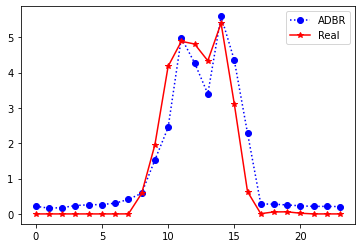

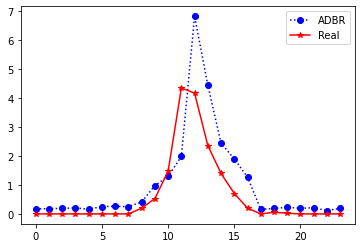

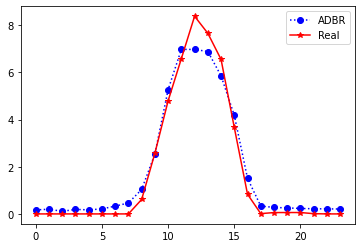

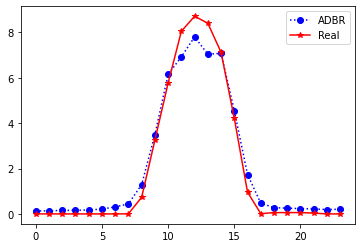

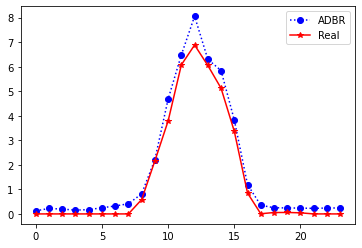

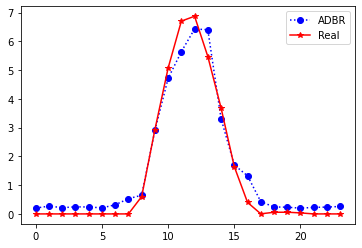

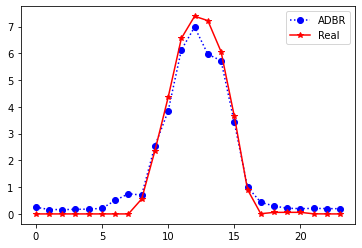

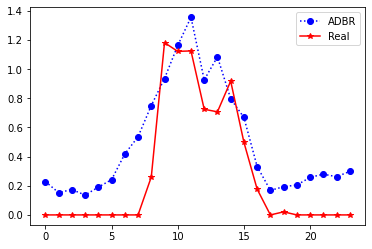

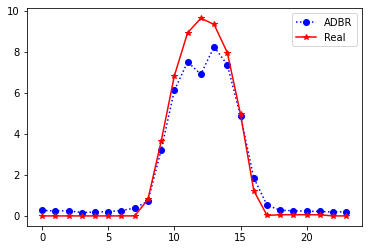

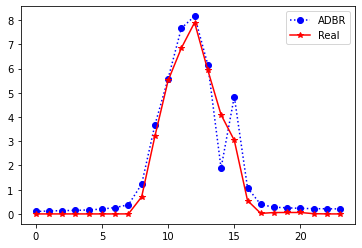

In [ ]:
import matplotlib.pyplot as plt

# 17520 부터 2020년 7월 data

for t in range (0,10): # 10개씩 plot figure 보고싶음
  date= t + 21  #-------- 보고싶은 구간 반영하여 0~21 까지 수동으로 더해주기
  Ans_date = 25584+date*24 # --- Answer 범위가 range-24부터 시작하니까 
  
  x=np.array(range(24))
  Y_adrg = adrg_pred[24*date:24*date+24]
  Answer = pd.Series(data[Ans_date-24:Ans_date]['전력거래량']).array
  
  plt.figure()
  plt.plot(x,Y_adrg,'bo:')
  plt.plot(x,Answer,'r*-')
  plt.legend(['ADBR','Real'])

In [ ]:
from sklearn.metrics import mean_absolute_error

score = mean_absolute_error(adrg.predict(x_pred),y_pred)
print('MAE of AdaBoostGRU :', max_val*score)

MAE of AdaBoostGRU : 0.38552401169637107


In [ ]:
import matplotlib.pyplot as plt

mae = history.history['mae']
val_mae=history.history['val_mae']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(mae) + 1) 

plt.plot(epochs, mae, label = 'Training mae')
plt.plot(epochs, val_mae, label = 'Validation mae')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()